This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I've read  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering and deep dive into linear regression analysis  but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models. For that purpose, we build two stacking classes  ( the simplest approach and a less simple one). 

As these classes are written for general purpose, you can easily adapt them and/or extend them for your regression problems. 
The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )



**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
np?

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd?

In [3]:
# %matplotlib inline
%matplotlib notebook

In [4]:
import matplotlib.pyplot as plt  # Matlab-style plotting
import matplotlib
plt?

In [5]:
import seaborn as sns
sns.color_palette?
color = sns.color_palette()

In [6]:
sns.set_style('darkgrid')

In [7]:
import warnings
warnings?

In [8]:
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [9]:
from scipy import stats

In [10]:
from scipy.stats import norm, skew #for some statistics

## let's start

In [11]:
str.format?

In [12]:
pd.set_option?

In [13]:
#Limiting floats output to 3 decimal points.
# specify the option first. Then pass a lambda function as the second argument which returns
# the string repesentation of the float number to three decimal points 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [14]:
from subprocess import check_output

In [15]:
check_output?

In [16]:
# check the files available in the directory
# use bash commands to get the list of files in the input folder as a byte array.
check_output(["ls", "../input"])

b'data_description.txt\nhouse-prices-advanced-regression-techniques\nsample_submission.csv\ntest.csv\ntrain.csv\n'

In [17]:
bytes.decode?

In [18]:
# continuing...
# then convert it to utf8 and print
print(check_output(["ls", "../input"]).decode("utf8"))

data_description.txt
house-prices-advanced-regression-techniques
sample_submission.csv
test.csv
train.csv



In [19]:
pd.read_csv?

In [20]:
#Now let's import and put the train and test datasets in  pandas dataframe
train = None
test = None

In [21]:
pd.DataFrame.head?

In [22]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [23]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [24]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [25]:
#Save the 'Id' column
train_ID = None
test_ID = None

In [26]:
pd.DataFrame.drop?
## make sure to drop one row (not column) and the changes to the dataframe will be inplace

In [27]:
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
None
None

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Data Processing

## Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data

[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


In [28]:
plt.subplots?

In [29]:
matplotlib.axes.Axes.scatter?

In [30]:
plt.ylabel?

In [31]:
plt.xlabel?

In [32]:
plt.show?

<IPython.core.display.Javascript object>


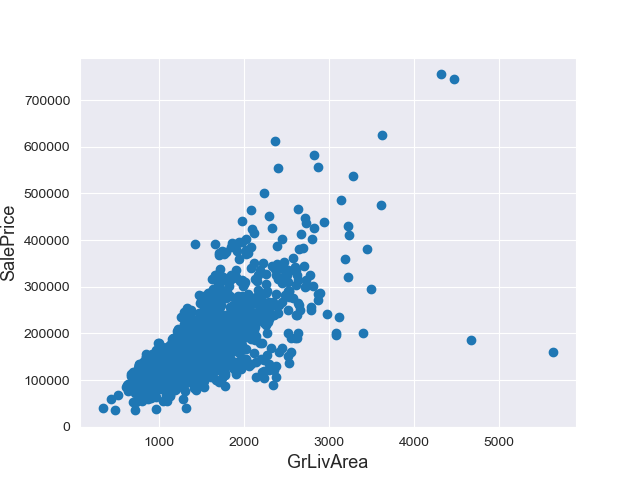

In [33]:
# create a figure and a set of subplots with one subplot
fig, ax = plt.subplots()

# create a scatter plot of SalePrice vs GrLivArea
None

plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

In [34]:
pd.DataFrame.drop?

In [35]:
pd.DataFrame.index?

In [36]:
# Deleting outliers
# get those rows of train set where the GrLivArea is greater than 4000 and the SalePrice is
# less than 300000. Then drop from the train set using the rows' indices 
train = None

<IPython.core.display.Javascript object>


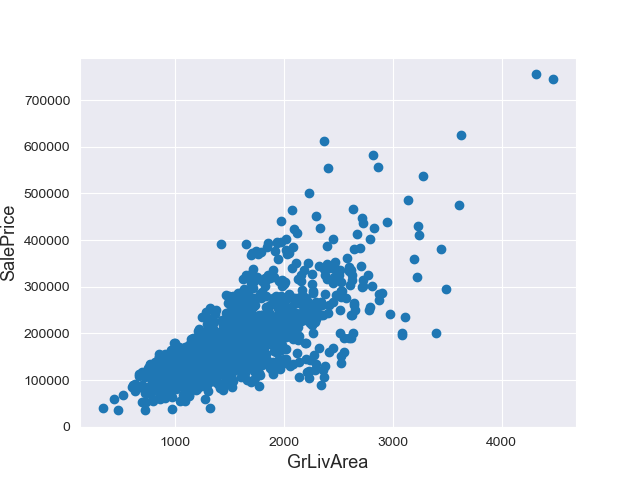

In [37]:
fig, ax = plt.subplots()

#Check the graphic again
None

plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Note : 
 Outliers removal is not always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

## Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.

In [38]:
sns.distplot?
# pass a random variable which will be fitted to the saleprice for creating the distribution plot

In [39]:
norm?

<IPython.core.display.Javascript object>


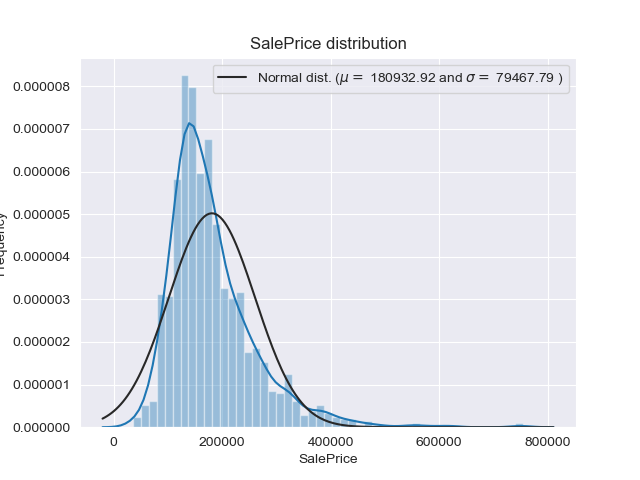

In [40]:
plt.figure()

#Now plot the distribution plot
None

In [41]:
norm.fit?

In [42]:
# Get the fitted parameters used by the function
(mu, sigma) = None

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 180932.92 and sigma = 79467.79



In [43]:
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Text(0.5, 1.0, 'SalePrice distribution')

In [44]:
stats?

In [45]:
stats.probplot?
# pass the pyplot object to show the plotting

<IPython.core.display.Javascript object>


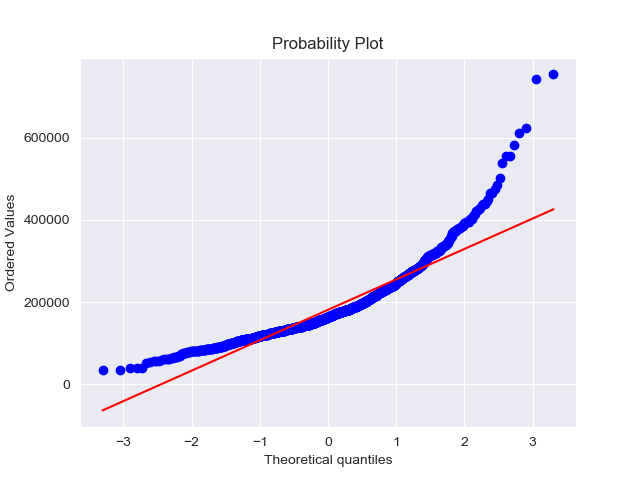

In [46]:
plt.figure()

#Get also the QQ-plot
None

plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**

In [47]:
np.log1p?

In [48]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
None

<IPython.core.display.Javascript object>


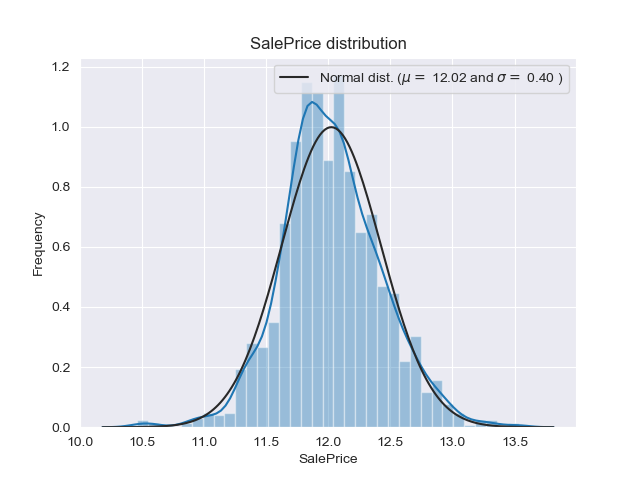

In [49]:
#Check the new distribution 
plt.figure()

# similar to above
None

In [50]:
# Get the fitted parameters used by the function
# similar to the above
None

In [51]:
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

Text(0.5, 1.0, 'SalePrice distribution')

<IPython.core.display.Javascript object>


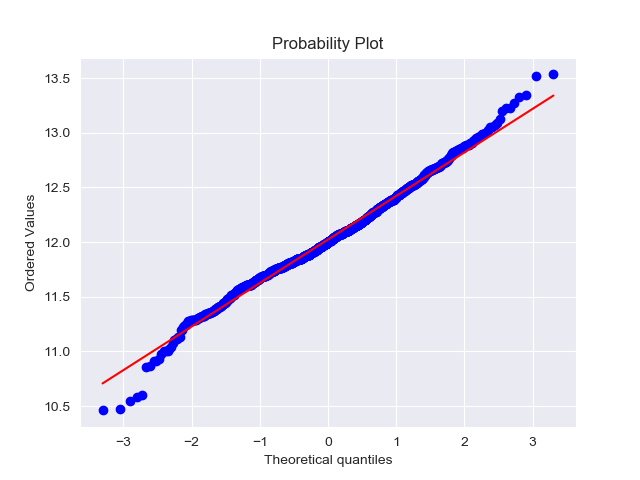

In [52]:
fig = plt.figure()

#Get also the QQ-plot
# similar to the above
None

plt.show()

The skew seems now corrected and the data appears more normally distributed. 

## Features engineering

let's first  concatenate the train and test data in the same dataframe

In [53]:
pd.DataFrame.shape?

In [54]:
# get number of rows of train and test dataframe
ntrain = None
ntest = None

print(ntrain)
print(ntest)

1458
1459


In [55]:
pd.Series.values?

In [56]:
# get the dependent variable column of train set
y_train = None

print(y_train)
print(y_train.shape)

[12.24769912 12.10901644 12.31717117 ... 12.49313327 11.86446927
 11.90159023]
(1458,)


In [57]:
pd.concat?

In [58]:
pd.DataFrame.reset_index?
# specify to drop the index

In [59]:
# concatanate the train and test dataframe and reset index. drop the previous indexing of the 
# joined dataframe
all_data = None

all_data.shape

(2917, 80)

In [60]:
pd.DataFrame.drop?

In [61]:
# drop the `SalePrice` column of `all_data`
# carefully drop one row (and not one column). All changes must be inplace
None

print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing Data

In [62]:
pd.DataFrame.isnull?

In [63]:
pd.DataFrame.sum?

In [64]:
len?

In [65]:
# get the percentage of missing values for every column
all_data_na_percentages = None

all_data_na_percentages

MSSubClass       0.000
MSZoning         0.137
LotFrontage     16.661
LotArea          0.000
Street           0.000
                 ...  
MiscVal          0.000
MoSold           0.000
YrSold           0.000
SaleType         0.034
SaleCondition    0.000
Length: 79, dtype: float64

In [66]:
pd.DataFrame.drop?

In [67]:
pd.DataFrame.index?

In [68]:
pd.DataFrame.sort_values?

In [69]:
# firstly, get the indexes of column-names which have no missing values
# then drop them using the indices
# sort them in descending
# order. Get the top 30 column names having the most missing values
all_data_na_nonzero_sorted = None

all_data_na_nonzero_sorted

PoolQC         99.691
MiscFeature    96.400
Alley          93.212
Fence          80.425
FireplaceQu    48.680
LotFrontage    16.661
GarageFinish    5.451
GarageYrBlt     5.451
GarageQual      5.451
GarageCond      5.451
GarageType      5.382
BsmtExposure    2.811
BsmtCond        2.811
BsmtQual        2.777
BsmtFinType2    2.743
BsmtFinType1    2.708
MasVnrType      0.823
MasVnrArea      0.788
MSZoning        0.137
BsmtFullBath    0.069
BsmtHalfBath    0.069
Utilities       0.069
Functional      0.069
Exterior2nd     0.034
Exterior1st     0.034
SaleType        0.034
BsmtFinSF1      0.034
BsmtFinSF2      0.034
BsmtUnfSF       0.034
Electrical      0.034
dtype: float64

In [70]:
pd.DataFrame?

In [71]:
# create a new Dataframe where the `Missing Ratio` column is the `all_data_na_nonzero_sorted`
missing_data = None

missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


In [72]:
plt.subplots?

<IPython.core.display.Javascript object>


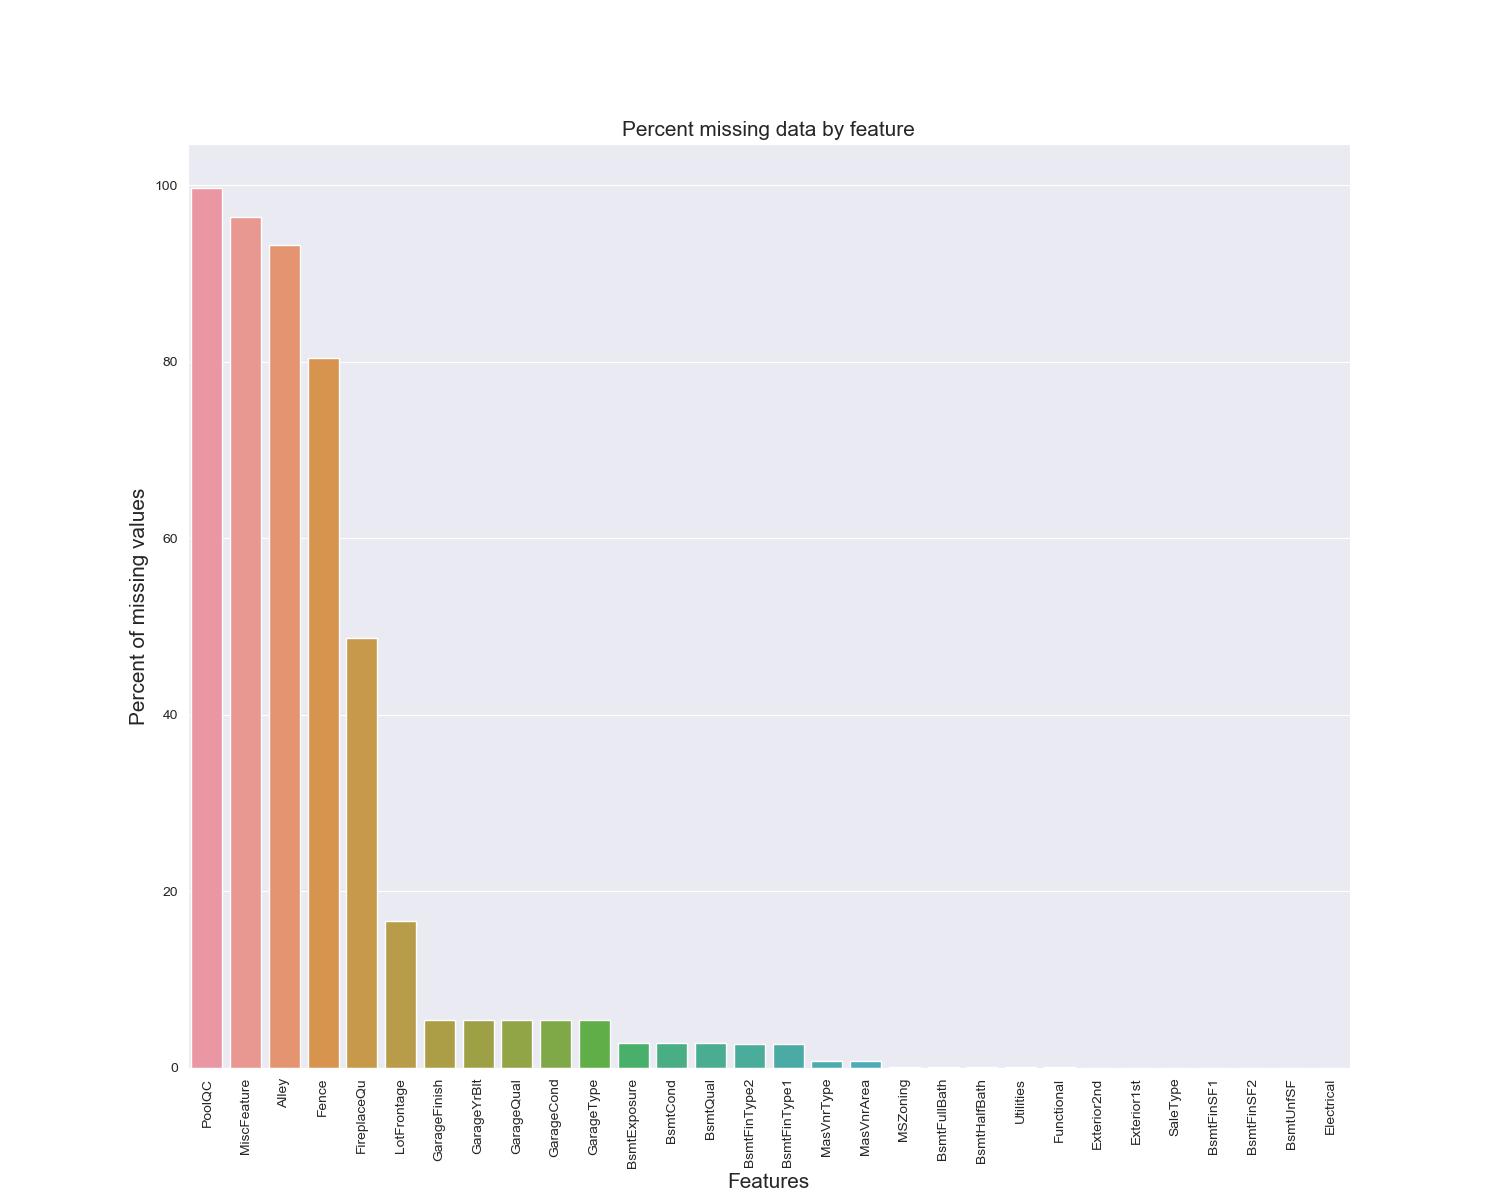

In [73]:
# create a figure with `subplots` where the figure size is (15,12)
f, ax = None

In [74]:
sns.barplot?

In [75]:
# create a barplot of all_data_na_nonzero_sorted
None

In [76]:
# adjustments
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Text(0.5, 1.0, 'Percent missing data by feature')

**Data Correlation**


In [77]:
pd.DataFrame.corr?

In [78]:
#Correlation map to see how features are correlated with SalePrice
corrmat = None

corrmat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000,-0.405,-0.142,0.033,-0.059,0.028,0.041,0.023,-0.074,-0.066,...,-0.013,-0.007,-0.012,-0.044,-0.026,0.008,-0.008,-0.014,-0.021,-0.074
LotFrontage,-0.405,1.000,0.389,0.235,-0.056,0.117,0.081,0.164,0.147,0.055,...,0.082,0.117,0.015,0.075,0.046,0.116,0.005,0.026,0.008,0.373
LotArea,-0.142,0.389,1.000,0.091,-0.003,0.007,0.008,0.085,0.175,0.114,...,0.169,0.062,-0.017,0.021,0.045,0.036,0.039,0.006,-0.014,0.261
OverallQual,0.033,0.235,0.091,1.000,-0.090,0.571,0.550,0.403,0.222,-0.058,...,0.237,0.297,-0.113,0.031,0.066,0.045,-0.031,0.073,-0.027,0.821
OverallCond,-0.059,-0.056,-0.003,-0.090,1.000,-0.376,0.075,-0.127,-0.043,0.040,...,-0.003,-0.030,0.070,0.025,0.055,0.002,0.069,-0.004,0.044,-0.037
YearBuilt,0.028,0.117,0.007,0.571,-0.376,1.000,0.592,0.313,0.250,-0.049,...,0.224,0.184,-0.387,0.032,-0.050,-0.005,-0.034,0.013,-0.013,0.587
YearRemodAdd,0.041,0.081,0.008,0.550,0.075,0.592,1.000,0.176,0.123,-0.067,...,0.205,0.223,-0.194,0.046,-0.038,-0.003,-0.010,0.022,0.036,0.566
MasVnrArea,0.023,0.164,0.085,0.403,-0.127,0.313,0.176,1.000,0.239,-0.072,...,0.157,0.105,-0.109,0.020,0.063,-0.021,-0.030,-0.004,-0.007,0.435
BsmtFinSF1,-0.074,0.147,0.175,0.222,-0.043,0.250,0.123,0.239,1.000,-0.050,...,0.205,0.073,-0.104,0.029,0.068,0.053,0.005,-0.004,0.016,0.392
BsmtFinSF2,-0.066,0.055,0.114,-0.058,0.040,-0.049,-0.067,-0.072,-0.050,1.000,...,0.068,0.005,0.036,-0.030,0.089,0.046,0.005,-0.015,0.032,0.005


<IPython.core.display.Javascript object>


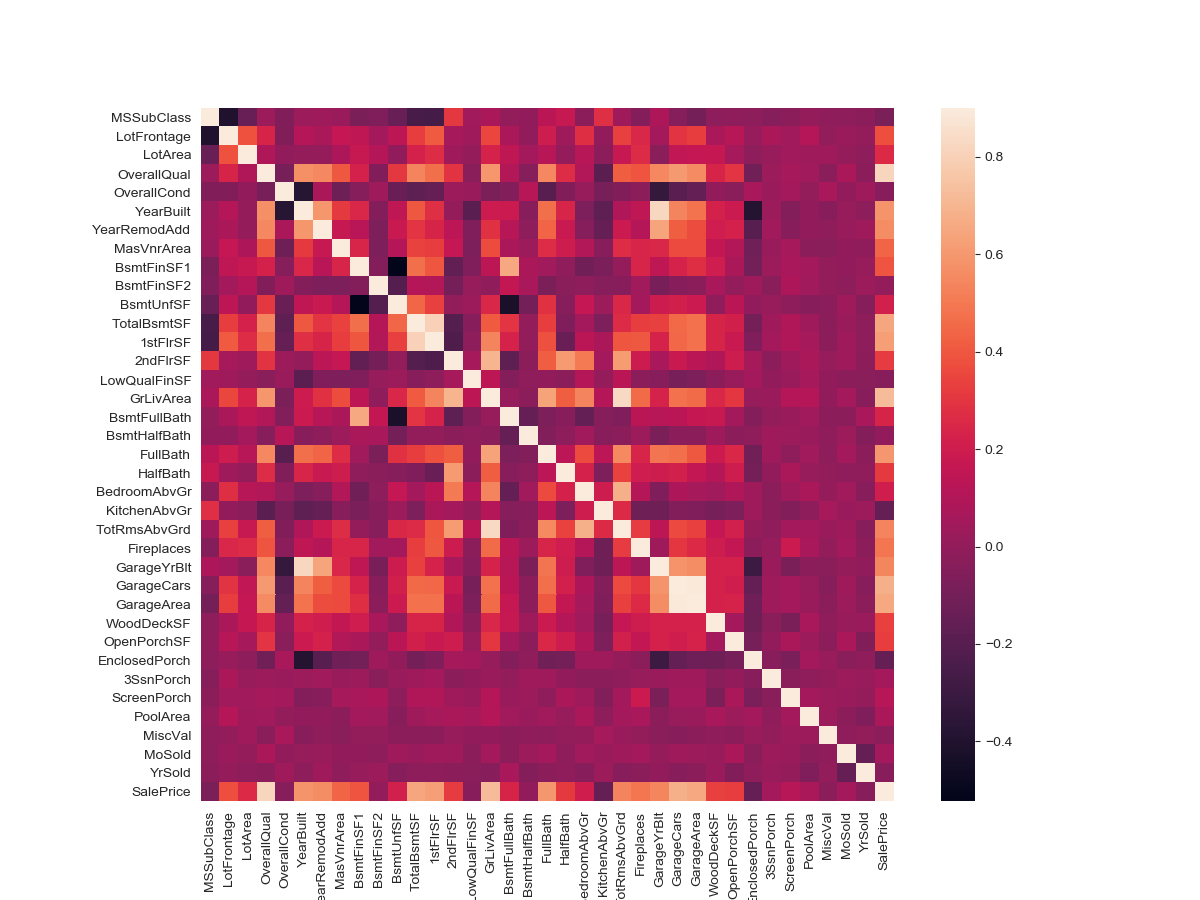

(<Figure size 1200x900 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01307b86d8>)

In [79]:
# create a figure with `subplots` where the figure size is (12,9)
None

In [80]:
sns.heatmap?

In [81]:
# draw a heatmap using the `corrmat` dataframe 
# specify 0.9 as the maximum value to anchor the colormap. Make sure the cells are square-shaped
None

### Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [82]:
pd.Series.fillna?
# all the lines that use fillna are exam lines

In [83]:
# fill missing values by "None"
all_data["PoolQC"] = None

- **MiscFeature** : data description says NA means "no misc feature"


In [84]:
# fill missing values by "None"
all_data["MiscFeature"] = None

- **Alley** : data description says NA means "no alley access"

In [85]:
# fill missing values by "None"
all_data["Alley"] = None

- **Fence** : data description says NA means "no fence"

In [86]:
# fill missing values by "None"
all_data["Fence"] = None

- **FireplaceQu** : data description says NA means "no fireplace"

In [87]:
# fill missing values by "None"
all_data["FireplaceQu"] = None

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [88]:
pd.core.groupby.SeriesGroupBy.transform?

In [89]:
pd.Series.fillna?

In [90]:
pd.Series.median?

In [91]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
#use lambda
all_data["LotFrontage"] = None

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [92]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    # fill missing values by "None"
    all_data[col] = None

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [93]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    # fill missing values by 0
    all_data[col] = None

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [94]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    # fill missing values by 0
    all_data[col] = None

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [95]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    # fill missing values by "None"
    all_data[col] = None

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [96]:
# fill missing values by "None"
all_data["MasVnrType"] = None

# fill missing values by 0
all_data["MasVnrArea"] = None

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [97]:
pd.Series.mode?

In [98]:
# get first mode(s) of `MSZoning` 
all_data['MSZoning'] = None

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [99]:
pd.DataFrame.drop?
# make sure to drop one column (not one row)

In [100]:
all_data = None

- **Functional** : data description says NA means typical

In [101]:
# fill missing values by "Typ"
all_data["Functional"] = None

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [102]:
# fill missing values by the first mode
all_data['Electrical'] = None

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [103]:
# fill missing values by the first mode
all_data['KitchenQual'] = None

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [104]:
# fill missing values by the first mode
all_data['Exterior1st'] = None
all_data['Exterior2nd'] = None

- **SaleType** : Fill in again with most frequent which is "WD"

In [105]:
# fill missing values by the first mode
all_data['SaleType'] = None

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [106]:
# fill missing values by "None"
all_data['MSSubClass'] = None

Is there any remaining missing value ? 

In [107]:
#Check remaining missing values if any 
#just like above
all_data_na = None
all_data_na = None

missing_data = None

missing_data.head()

,Missing Ratio


It remains no missing value.


### More features engeneering

**Transforming some numerical variables that are really categorical**

In [108]:
pd.Series.apply?

In [109]:
str?

In [110]:
pd.Series.astype?

In [111]:
#MSSubClass=The building class. apply the necessary function to convert the column entries into
#strings
all_data['MSSubClass'] = None

#Changing OverallCond into a categorical variable (string)
all_data['OverallCond'] = None

#Year and month sold are transformed into categorical features. (string)
all_data['YrSold'] = None
all_data['MoSold'] = None

**Label Encoding some categorical variables that may contain information in their ordering set** 

In [112]:
from sklearn.preprocessing import LabelEncoder

In [113]:
LabelEncoder?

In [114]:
# LabelEncoder()
import sklearn
sklearn.preprocessing.LabelEncoder.fit?

In [115]:
list?

In [116]:
sklearn.preprocessing.LabelEncoder.transform?

In [117]:
pd.Series.values?

In [118]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    # create a label encoder for each column c
    lbl = None
    
    # get all `values` of column `c`.
    # create a list
    # and fit the label encoder
    None
    
    # get all `values` of column `c`.
    # create a list
    # and transform the column using the label encoder
    all_data[c] = None

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [119]:
# Adding total sqfootage feature 
# add `TotalBsmtSF`,`1stFlrSF`, `2ndFlrSF` to create a new column `TotalSF`
all_data['TotalSF'] = None

all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,10,RL,65.000,8450,1,1,3,Lvl,Inside,0,...,0,3,4,None,0,4,2,WD,Normal,2566.000
1,5,RL,80.000,9600,1,1,3,Lvl,FR2,0,...,0,3,4,None,0,7,1,WD,Normal,2524.000
2,10,RL,68.000,11250,1,1,0,Lvl,Inside,0,...,0,3,4,None,0,11,2,WD,Normal,2706.000
3,11,RL,60.000,9550,1,1,0,Lvl,Corner,0,...,0,3,4,None,0,4,0,WD,Abnorml,2473.000
4,10,RL,84.000,14260,1,1,0,Lvl,FR2,0,...,0,3,4,None,0,3,2,WD,Normal,3343.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2,RM,21.000,1936,1,1,3,Lvl,Inside,0,...,0,3,4,None,0,8,0,WD,Normal,1638.000
2913,2,RM,21.000,1894,1,1,3,Lvl,Inside,0,...,0,3,4,None,0,6,0,WD,Abnorml,1638.000
2914,5,RL,160.000,20000,1,1,3,Lvl,Inside,0,...,0,3,4,None,0,11,0,WD,Abnorml,2448.000
2915,14,RL,62.000,10441,1,1,3,Lvl,Inside,0,...,0,3,2,Shed,700,9,0,WD,Normal,1882.000


**Skewed features**

In [120]:
pd.DataFrame.dtypes?

In [121]:
pd.Series.index?

In [122]:
# get the names of columns of `all_data` which are not of object type
numeric_feats = None

numeric_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF'],
      dtype='object')

In [123]:
pd.DataFrame.apply?
# specify lambda

In [124]:
skew?

In [125]:
pd.Series.dropna?

In [126]:
pd.DataFrame.sort_values?
# specify `ascending`

In [127]:
# Check the skew of all numerical features
# `apply` a lambda function to the numeric features. In the lambda function-
# firstly, drop the NA values of a numeric column. Then sort them in descending order
# pass the column in the `skew` function return the result 
skewed_feats = None

In [128]:
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]

[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [129]:
abs?

In [130]:
# only take those values of skewness where the absolute value is over 0.75
skewness_selected = None
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform


In [131]:
from scipy.special import boxcox1p

# get the names of columns having the skewness above the threshold
skewed_features = None

# a lambda value of 0.15 is selected
lam = 0.15

In [132]:
boxcox1p?
# pass a lambda value
# https://www.statisticshowto.com/box-cox-transformation/

In [133]:
# apply the box cox transformation on those columns of `all_data` which had a skewness greater
# then the threshold
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = None
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

**Getting dummy categorical features**

In [134]:
pd.get_dummies?

In [135]:
# create dummy variables in the whole dataset.
# only the caegorical columns will be converted to dummy variables
all_data = None
print(all_data.shape)

(2917, 220)


Getting the new train and test sets. 

In [136]:
# We have completed the preprocessing of our whole dataset, it's time to split the 
# merged dataset into train and test dataframes
train = None
test = None

# Modelling

**Import librairies**

In [137]:
# !conda install -c conda-forge xgboost

In [138]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [139]:
KFold?
# specify the number of splits, shuffle the dataset
# random_state=42

In [140]:
sklearn.model_selection._split.KFold.get_n_splits?

In [141]:
np.sqrt?
# make sure to pass the negative of cross validation

In [142]:
cross_val_score?
# pass the model, training values and y_train. The model will be evaluated on negative mean
# squared error `neg_mean_squared_error`. Pass the number of splitting iterations too 

In [143]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    # create a kfold cross validator object and get the number of splitting iterations
    kf = None
    
    # get the root mean square value of the train values
    # remember to negate the return of cross validation.
    rmse= None
    
    return(rmse)

# testing
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
rmsle_cv(lasso)

array([0.1039154 , 0.11461747, 0.12421385, 0.10529784, 0.10967219])

## Base models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

Follow the link below to understand lasso regression

https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

In [144]:
make_pipeline?

In [145]:
RobustScaler?

In [146]:
Lasso?
# the lambda in the above article is used as alpha in this function
# use 0.0005
# random_state=1

In [147]:
lasso = None

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



- **Elastic Net Regression** :

again made robust to outliers

Get a good resource to understand this

In [148]:
ElasticNet?
# specify alpha=0.0005, l1_ratio=0.9, random_state=3

In [149]:
ENet = None

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



- **Kernel Ridge Regression** :

Get a good resource to understand this

In [150]:
KernelRidge?
# specify alpha=0.6, kernel=polynomial, degree=2, coef0=2.5

In [151]:
KRR = None

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers

Get a good resource to understand this
    

In [152]:
GradientBoostingRegressor?
# specify n_estimators=3000, learning_rate=0.05, max_depth=4, max_features=sqrt, 
# min_samples_leaf=15, min_samples_split=10, loss=huber, random_state =5

In [153]:
GBoost = None

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



- **XGBoost** :

Get a good resource to understand this

In [154]:
xgb?

In [155]:
xgb.XGBRegressor?
# colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=2200,
# reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state =7, nthread = -1

In [156]:
model_xgb = None

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1172 (0.0050)



- **LightGBM** :

Get a good resource to understand this

In [157]:
lgb?

In [158]:
lgb.LGBMRegressor?
# objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, 
# bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,
# feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11

In [159]:
model_lgb = None

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1170 (0.0063)



### Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

This part is already done with declaring the models

## Stacking  models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [160]:
BaseEstimator?

In [161]:
RegressorMixin?

In [162]:
TransformerMixin?

In [163]:
# create a class that inherits the above three classes
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        

In [164]:
averaged_models = AveragingModels(models = (ENet, GBoost))

In [165]:
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        
        # make a new list of cloned models
        self.models_ = None
        
        # Train cloned base models
        for model in None:
            None

        return self

AveragingModels.fit=fit

In [166]:
x_sample=np.array([1,3,5,7,9]).reshape(5,1)
y_sample=np.array([2,6,10,14,18]).reshape(5,1)
averaged_models.fit(x_sample,y_sample)

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                                    random_state=3))]),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=3000,
                                                  random_state=5)))

In [167]:
np.column_stack?

In [168]:
#Now we do the predictions for cloned models and average them
def predict(self, X):
    
    # create an empty list to store the predictions from the models
    predictions=None
    
    # iterate through the models
    for model in None:
        
        # pass all of the independent variable rows to each model and get a prediction
        prediction = None
        
        # append the prediction to the list of predictions
        None
    
    # Take the sequence of 1-D predictions and stack them as columns to make a single 2-D array
    # so that one row of independent variable gets predictions of 
    # the dependent variable from ENet, GBoost, KRR, lasso models
    stacked_predictions = None
    
    # get the average of the predictions of the dependent variable for each row and return.
    # specify that we need to average one row of predictions of the dependent variable
    return None

AveragingModels.predict=predict

In [169]:
x_test_sample = np.array([2,4,6,8,10]).reshape(5,1)
averaged_models.predict(x_test_sample)

array([ 7.00063744,  9.00021248, 10.99978752, 12.99936256, 14.99893761])

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [170]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

In [171]:
# import dill
# dill.dump_session('saved_model/notebook_env.db')

In [172]:
# import dill
# dill.load_session('saved_model/notebook_env.db')

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

Gif taken from [KazAnova's interview](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [173]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   

In [174]:
list?

In [175]:
clone?

In [176]:
KFold?

In [177]:
np.zeros?

In [178]:
enumerate?

In [179]:
KFold.split?

In [180]:
list.append?

In [181]:
    # We again fit the data on clones of the original models
    def fit(self, X, y,verbose=False):
        # create a list of empty lists for all the base_models
        # each of the empty lists will have K instances of the base model 
        self.base_models_ = None
        
        # clone the meta_model_ 
        self.meta_model_ = None
        
        # create a K-Folds cross-validator. Set the number of folds. Shuffle the data and 
        # set the random_state=156
        kfold = None
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        
        # out_of_fold_predictions is an array which is initialized by zero and has 
        # the shape amount of data X number of base_models
        # each row of out_of_fold_predictions will contain the dependent variable predictions
        # of the corresponding row of the main dataset.
        # each row will contain a prediction from each of the base models.
        out_of_fold_predictions = None
        
        # base_models contains the instances of ENet, GBoost, KRR. Wrap it in enumerate
        # to access the model and get an index
        for i, model in None:#exam
            if verbose: print("Model ",str(i),":___________________")
            fold=0
            for train_index, holdout_index in kfold.split(X, y):
                if verbose: print("fold:",fold)
                fold=fold+1
                if verbose: print("train_index:",train_index)
                if verbose: print("holdout_index:",holdout_index)
                
                # clone the base model 
                instance = None
                
                # append the clonned model to the list that contains all instances of
                # the base model. For example, an instance of lasso model should be appended
                # with the list which contains the instances of lassl model trained on specific 
                # folds
                None
                
                # we have the rows of the dataset which are to be used as the folds (k-1) 
                # for training the instance of our base model. So, we will train our current 
                # instance on those specific rows of our dataset
                
                None
                
                # we also have a holdout set (1 fold of rows from the dataset) and we will get 
                # the predict the dependent variable of that holdout set
                
                y_pred = None
                
                # We will save the predictions of the holdout set.
                # The rows of out_of_fold_predictions indicate the rows of the dataset.
                # The columns of out_of_fold_predictions indicate the base models
                # for example out_of_fold_predictions[12,3] is the predicted value of the
                # 3rd model for the independent variables of the 12th row of the dataset
                out_of_fold_predictions[holdout_index, i] = None
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        None
        return self
    
StackingAveragedModels.fit=fit

# testing
x_sample=np.array([1,2,3,4,5]).reshape(5,1)
y_sample=np.array([2,4,6,8,10]).reshape(5,1)

sample_model=StackingAveragedModels(base_models = (ENet, GBoost), meta_model = lasso).fit(x_sample,y_sample,verbose=True)

Model  0 :___________________
fold: 0
train_index: [0 1 2 4]
holdout_index: [3]
fold: 1
train_index: [0 2 3 4]
holdout_index: [1]
fold: 2
train_index: [0 1 3 4]
holdout_index: [2]
fold: 3
train_index: [1 2 3 4]
holdout_index: [0]
fold: 4
train_index: [0 1 2 3]
holdout_index: [4]
Model  1 :___________________
fold: 0
train_index: [0 1 2 4]
holdout_index: [3]
fold: 1
train_index: [0 2 3 4]
holdout_index: [1]
fold: 2
train_index: [0 1 3 4]
holdout_index: [2]
fold: 3
train_index: [1 2 3 4]
holdout_index: [0]
fold: 4
train_index: [0 1 2 3]
holdout_index: [4]


In [182]:
np.column_stack?

In [183]:
sample = [[1,2,3,4,5],[6,7,8,9,10]]
print(np.column_stack(sample))
print(np.column_stack(sample).mean(axis=1))

[[ 1  6]
 [ 2  7]
 [ 3  8]
 [ 4  9]
 [ 5 10]]
[3.5 4.5 5.5 6.5 7.5]


In [184]:
#     #Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)
    
# StackingAveragedModels.predict=predict

In [185]:
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X, verbose=False):
        
        # create and empty list to hold the predictions of ENet, GBoost, KRR
        base_model_prediction_list=None
        
        # self.base_models_ contains ENet, GBoost, KRR
        
        base_model_count=0
        for base_models in self.base_models_:
            
            if verbose: print("Base Model:",base_model_count,"___________________________")
            
            # this is an empty list that holds the predictions of K folds of a base_model
            # for example- 5 predictions from 5 folds of ENet
            prediction_list_of_KFolds=None
            
            # `model` was trained by one of the K folds of the dataset and model is an instance
            # of one of ENet, GBoost, KRR
            model_count=0
            for model in base_models:
                if verbose: print("Model:",model_count)
                
                # predict the whole dataset using a model that was trained on one fold
                prediction_of_fold=None
                
                if verbose: print("prediction of model ",model_count,":",prediction_of_fold)
                    
                # append the prediction of a model to the list of predictions of base_models so
                # that we can average them
                None
                
                model_count+=1
            
            # get the mean of the predictions got from models which were trained on one fold
            # of the dataset.
            if verbose: print("prediction of base model ",base_model_count,":",prediction_list_of_KFolds)
            
            base_model_prediction = None
            
            if verbose: print("base_model_prediction:",base_model_prediction)
            
            None
            
            base_model_count=base_model_count+1
        
        if verbose: print("base_model_prediction_list:",base_model_prediction_list)
        
        meta_features=None
        if verbose: print("meta_features:",meta_features)
        
        return None
    
StackingAveragedModels.predict=predict

# testing
x_sample_test=np.array([2,4,6,8,10]).reshape(5,1)
sample_model.predict(x_sample_test,verbose=True)

Base Model: 0 ___________________________
Model: 0
prediction of model  0 : [ 4.00037497  7.99937504 11.99837511 15.99737518 19.99637525]
Model: 1
prediction of model  1 : [ 4.00062496  7.99962503 11.9986251  15.99762517 19.99662524]
Model: 2
prediction of model  2 : [ 4.00069991  7.99930009 11.99790026 15.99650044 19.99510061]
Model: 3
prediction of model  3 : [ 4.0010799   7.99964003 11.99820016 15.99676029 19.99532042]
Model: 4
prediction of model  4 : [ 4.00035997  7.9989201  11.99748023 15.99604036 19.99460049]
prediction of base model  0 : [array([ 4.00037497,  7.99937504, 11.99837511, 15.99737518, 19.99637525]), array([ 4.00062496,  7.99962503, 11.9986251 , 15.99762517, 19.99662524]), array([ 4.00069991,  7.99930009, 11.99790026, 15.99650044, 19.99510061]), array([ 4.0010799 ,  7.99964003, 11.99820016, 15.99676029, 19.99532042]), array([ 4.00035997,  7.9989201 , 11.99748023, 15.99604036, 19.99460049])]
base_model_prediction: [ 4.00062794  7.99937206 11.99811617 15.99686029 19.99

array([ 4.00028304,  7.99971696, 11.99915088, 15.9985848 , 19.99801872])

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [186]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


In [187]:
#Stacking Averaged models score: 0.1081 (0.0073)

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the **StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [188]:
np.sqrt?

In [189]:
sklearn.metrics.mean_squared_error?

In [190]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [191]:
 np.expm1?

In [192]:
# we are going to fit the train values to the stacked averaged model
stacked_averaged_models.fit(train.values, y_train)

# next, we are going to calculate the train error by predicting the dependent variable with the 
# train set and then, we are going to calculate root mean square error between the predicted value
# and the original value
stacked_train_pred = stacked_averaged_models.predict(train.values)
print(rmsle(y_train, stacked_train_pred))

# since all our weights of the models were trained on the np.log1 of y_train due to
# normalization and skewness reduction,
# we will get the correct prediction by passing the return value of 'predict' method through
# the reverse natural logarithm (exponential function e^x -1 ). 
stacked_pred = None


0.07839506096666017


**XGBoost:**

In [193]:
# fit XGBoost model on train set
None

# calculate the train error
xgb_train_pred = None
print(rmsle(y_train, xgb_train_pred))#exam

# get the test set predictions. remember to do the reverse of log1p
xgb_pred = np.expm1(model_xgb.predict(test))
xgb_pred

0.07904601516607457


array([119853.94, 162759.38, 184036.4 , ..., 165751.1 , 121451.93,
       216960.78], dtype=float32)

**LightGBM:**

In [194]:
# fit LightGBM model on train set
None

# calculate the train error
lgb_train_pred = None
print(rmsle(y_train, lgb_train_pred))

# get the test set predictions. remember to do the reverse of log1p
lgb_pred = np.expm1(model_lgb.predict(test.values))
lgb_pred

0.07282589114600178


array([124070.88244386, 157914.89197481, 183494.67715868, ...,
       160007.60156025, 115446.39791359, 218999.11958158])

In [195]:
# weighted average of stacked model, xg boost, and lightGBM. stacked model gets the most weight
# in the averaging (70%). both XGB and LGB gets 15% weight each
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(None)# exam

RMSLE score on train data:
0.07566748201010857


**Ensemble prediction:**

In [196]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [197]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)